In [42]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import os
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["axes.unicode_minus"] = False
import statsmodels.api as sm

In [146]:
DATA_ROOT = '~/projects/factormaster'
START_DATE = pd.to_datetime('2014-02-01')
END_DATE = pd.to_datetime('2020-11-30')

In [154]:
def _parse_factor_path(model_name, prefix):
    special_map = {'Carhart4': 'c4'}
    suffix = special_map.get(model_name, model_name)
    factor_path = os.path.join(DATA_ROOT, f'data/payoffs/pricing_factors/{model_name}/{prefix.lower()}_{suffix.lower()}.csv')
    return factor_path

def _load_model(factor_path, start_date, end_date):
    df = pd.read_csv(factor_path, index_col=0, parse_dates=True)
    df = df.loc[start_date: end_date]
    return df

def analyse_factor_on_model(factor, model_name, prefix, start_date, end_date, regression_length = 252):
    model_df = _load_model(_parse_factor_path(model_name, prefix), start_date, end_date)
    RF = model_df[['RF']]
    model_df['MKT'] = model_df['MKT'] - model_df['RF']
    model_df.drop('RF', axis=1, inplace=True)
    
    factor = factor.copy().loc[start_date: end_date]
    
    # all time correlation
    all_df = pd.concat([model_df, factor], axis=1)
    corr_df = all_df.corr().iloc[[-1], :-1]
    print("All Time Correlation")
    display(corr_df)
    
    # time series of correlation
    if regression_length > 0:
        ts_corr_df = pd.DataFrame(index = model_df.index[regression_length:], columns=model_df.columns)
        for i in range(regression_length, len(model_df.index)):
            ts_corr_df.loc[model_df.index[i]] = all_df.iloc[i-regression_length: i].corr().iloc[-1, :-1]
        print("Time Series of Correlation")
        ts_corr_df.plot()
        plt.show()
    
    # all time loading
    X = sm.add_constant(model_df)
    Y = factor
    m = sm.OLS(Y, X)
    rslt = m.fit()
    display(rslt.summary())
    print("=================")
    print(f"alpha p.a.: {(- RF['RF'] + rslt.params.iloc[0]).mean() * 252}")
    (rslt.resid - RF['RF'] + rslt.params.iloc[0] + 1).cumprod().plot()
    plt.gca().set_title("Cumulative Excess Return")
    plt.show()
    print("=================")
    
    # time series loading
    if regression_length:
        ts_loading_df = pd.DataFrame(index = model_df.index[regression_length:], columns=model_df.columns.tolist())
        excess_rtn_df = pd.DataFrame(index = model_df.index[regression_length:], columns=['alpha'])
        for i in range(regression_length, len(model_df.index)):
            tmp = all_df.iloc[i-regression_length: i]
            X = tmp.iloc[:, :-1]
            X = sm.add_constant(X)
            Y = tmp.iloc[:, [-1]]
            rslt = sm.OLS(Y, X).fit()
            ts_loading_df.loc[model_df.index[i]] = rslt.params.values[1:]
            excess_rtn_df.loc[model_df.index[i]] = rslt.resid.iloc[-1] - RF['RF'].loc[model_df.index[i]] + rslt.params.values[0]
        ts_loading_df.plot()
        plt.gca().set_title("Time Series of Loading")
        plt.show()
        (excess_rtn_df + 1).cumprod().plot()
        plt.gca().set_title("Time Series Derived Excess Return")
        plt.show()
    
    return

All Time Correlation


,MKT,SMB,HML
UMD,0.059049,0.111516,-0.352074


Time Series of Correlation


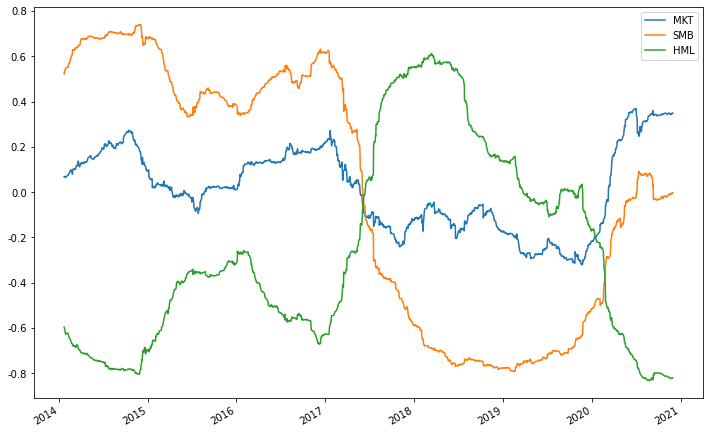

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    UMD   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     110.3
Date:                Thu, 24 Dec 2020   Prob (F-statistic):           7.21e-66
Time:                        18:20:47   Log-Likelihood:                 7049.3
No. Observations:                1922   AIC:                        -1.409e+04
Df Residuals:                    1918   BIC:                        -1.407e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.471e-05      0.000      0.529      0.597      -0.000       0.000
MKT            0.0080      0.010      0.787      0.431      -0.012       0.028
SMB           -0.1513      0.021     -7.215      0.000      -0.192      -0.110
HML           -0.3973      0.023    -17.312      0.000      -0.442      -0.352
==============================================================================
Omnibus:                      121.015   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              480.503
Skew:                          -0.149   Prob(JB):                    4.57e-105
Kurtosis:                       5.431   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.006555272096230748


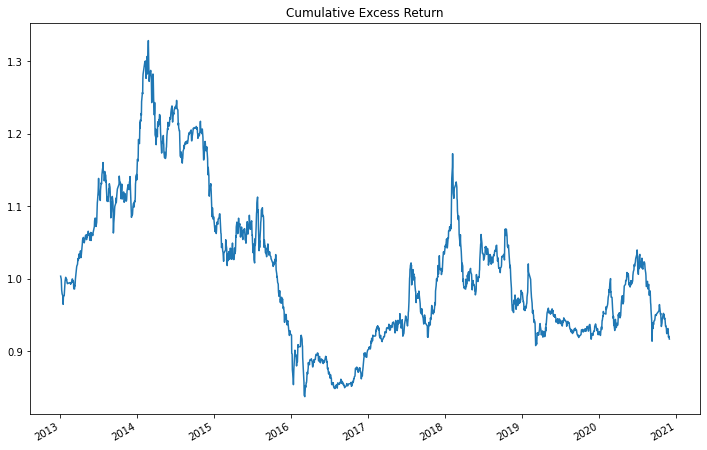

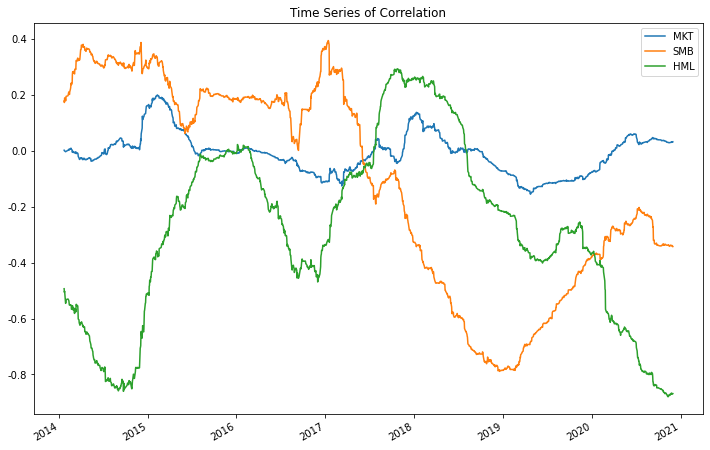

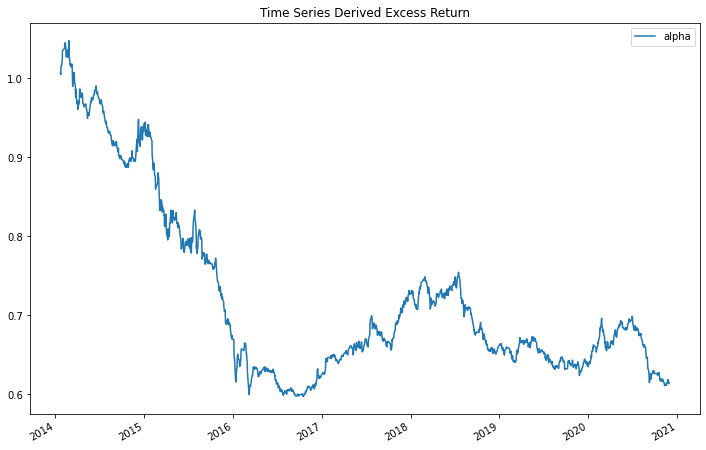

In [141]:
factor = _load_model(_parse_factor_path('Carhart4', 'classic'), START_DATE, END_DATE)[['UMD']]

rslt = analyse_factor_on_model(factor, 'FF3', 'classic', START_DATE, END_DATE)

All Time Correlation


,MKT
SMB,0.217751


Time Series of Correlation


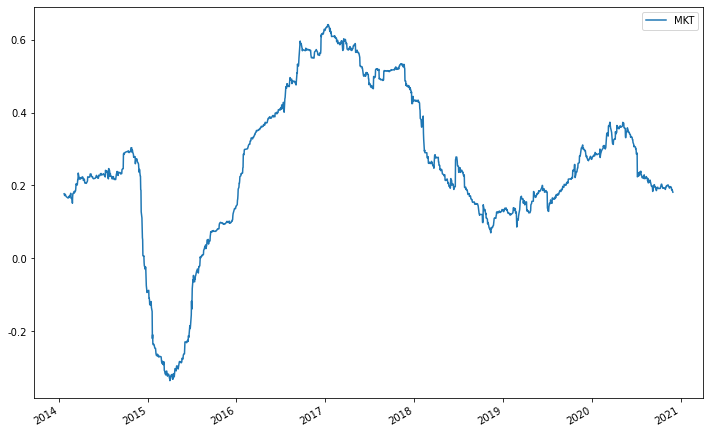

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SMB   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     95.57
Date:                Thu, 24 Dec 2020   Prob (F-statistic):           4.63e-22
Time:                        18:20:54   Log-Likelihood:                 6402.1
No. Observations:                1922   AIC:                        -1.280e+04
Df Residuals:                    1920   BIC:                        -1.279e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.903      0.367      -0.000       0.001
MKT            0.1368      0.014      9.776      0.000       0.109       0.164
==============================================================================
Omnibus:                      486.389   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3165.870
Skew:                          -1.024   Prob(JB):                         0.00
Kurtosis:                       8.945   Cond. No.                         70.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.019551940300658155


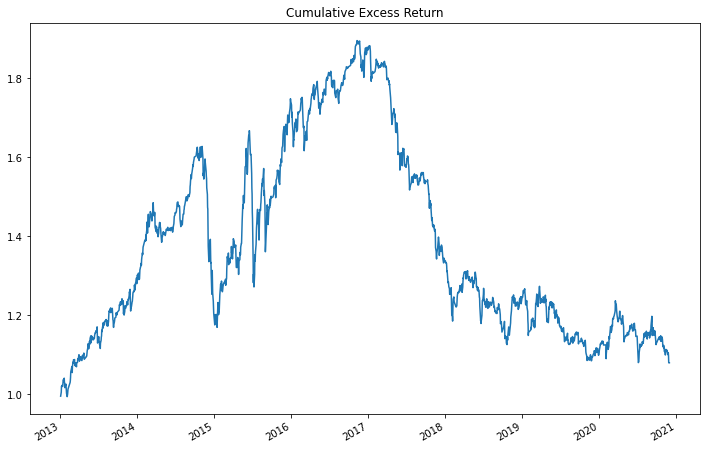

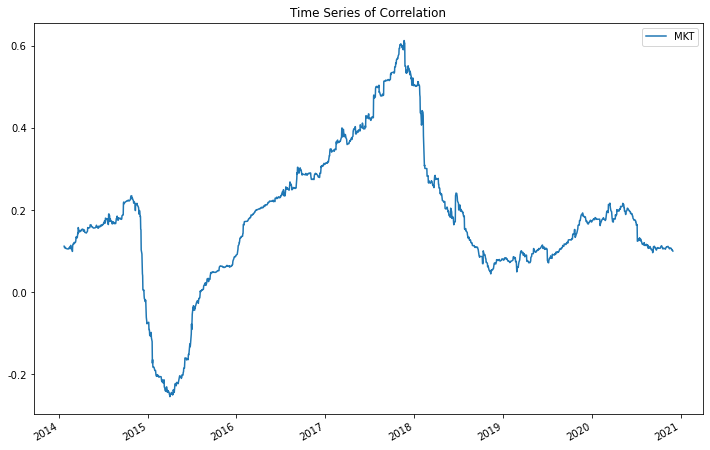

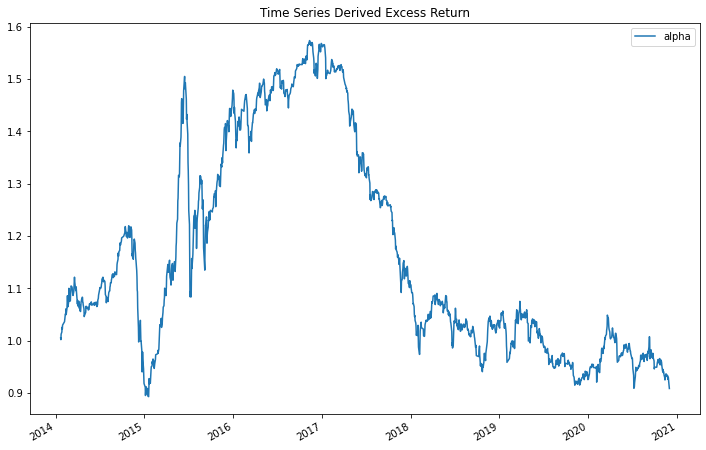

In [142]:
factor = _load_model(_parse_factor_path('FF3', 'classic'), START_DATE, END_DATE)[['SMB']]

analyse_factor_on_model(factor, 'CAPM', 'classic', START_DATE, END_DATE)

All Time Correlation


,MKT
UMD,0.063062


Time Series of Correlation


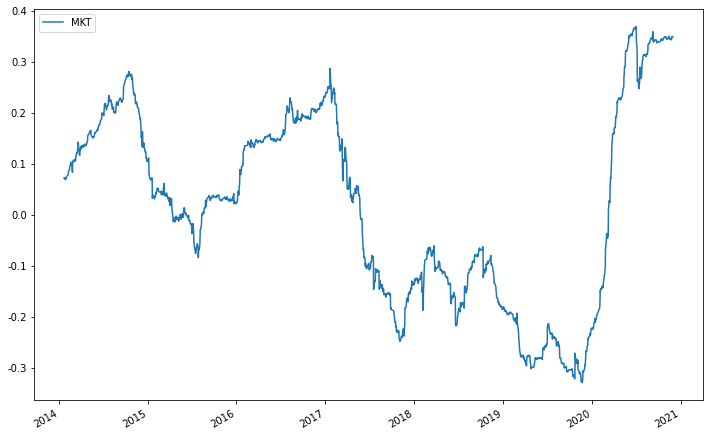

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    UMD   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.666
Date:                Thu, 24 Dec 2020   Prob (F-statistic):            0.00568
Time:                        18:21:01   Log-Likelihood:                 6900.2
No. Observations:                1922   AIC:                        -1.380e+04
Df Residuals:                    1920   BIC:                        -1.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.461e-05      0.000      0.358      0.720      -0.000       0.000
MKT            0.0299      0.011      2.769      0.006       0.009       0.051
==============================================================================
Omnibus:                      183.241   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              699.129
Skew:                          -0.409   Prob(JB):                    1.53e-152
Kurtosis:                       5.839   Cond. No.                         70.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: -0.01162059936722909


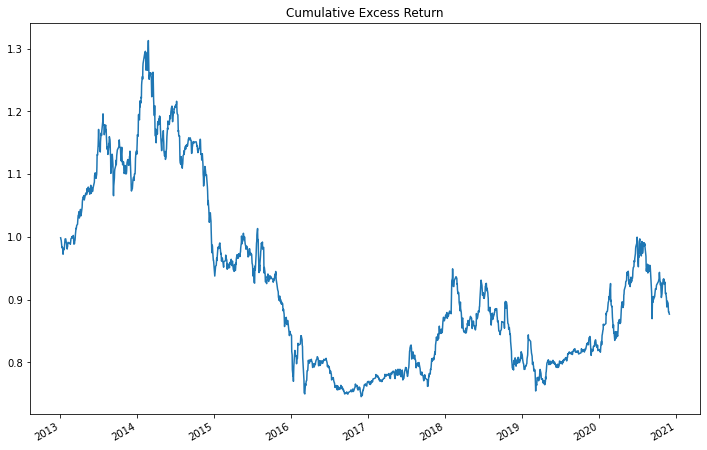

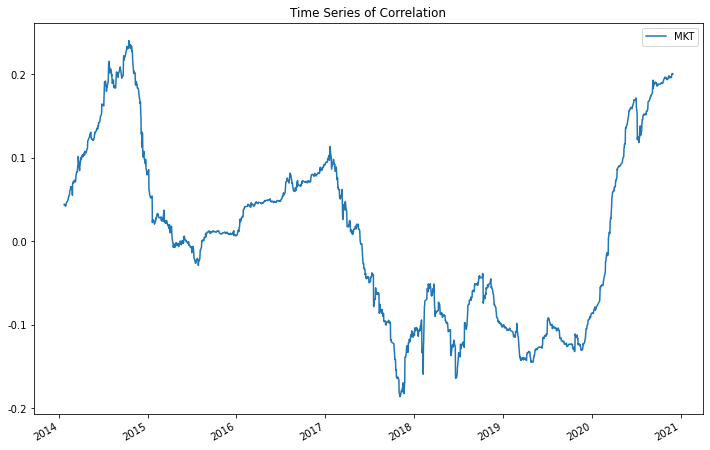

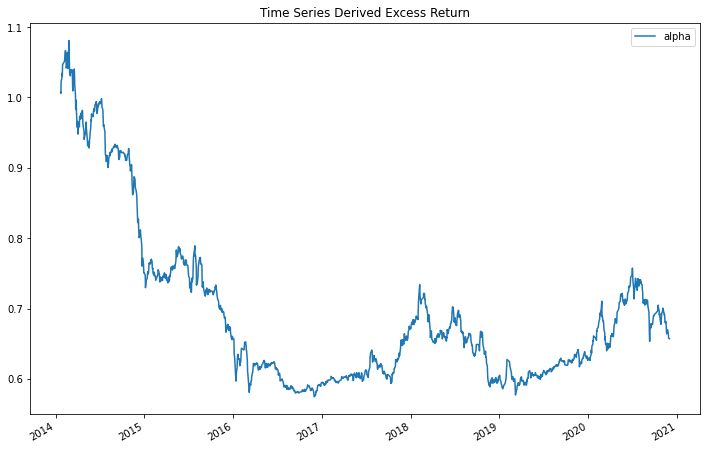

In [143]:
factor = _load_model(_parse_factor_path('Carhart4', 'classic'), START_DATE, END_DATE)[['UMD']]

analyse_factor_on_model(factor, 'CAPM', 'classic', START_DATE, END_DATE)

All Time Correlation


,MKT,SMB,HML
ROE_0011,-0.236522,-0.731345,0.372998


Time Series of Correlation


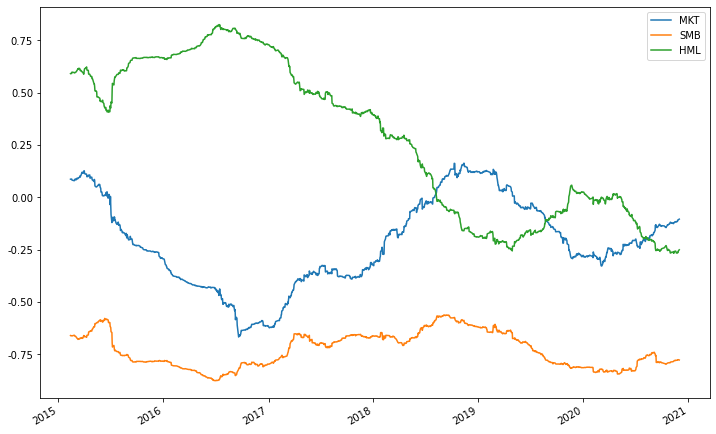

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ROE_0011   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     822.4
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:21:44   Log-Likelihood:                 6052.9
No. Observations:                1663   AIC:                        -1.210e+04
Df Residuals:                    1659   BIC:                        -1.208e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      6.910      0.000       0.001       0.001
MKT           -0.0629      0.011     -5.835      0.000      -0.084      -0.042
SMB           -0.5953      0.014    -42.853      0.000      -0.623      -0.568
HML           -0.2066      0.013    -15.936      0.000      -0.232      -0.181
==============================================================================
Omnibus:                      183.838   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              957.062
Skew:                           0.380   Prob(JB):                    1.50e-208
Kurtosis:                       6.638   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.2480946331106218


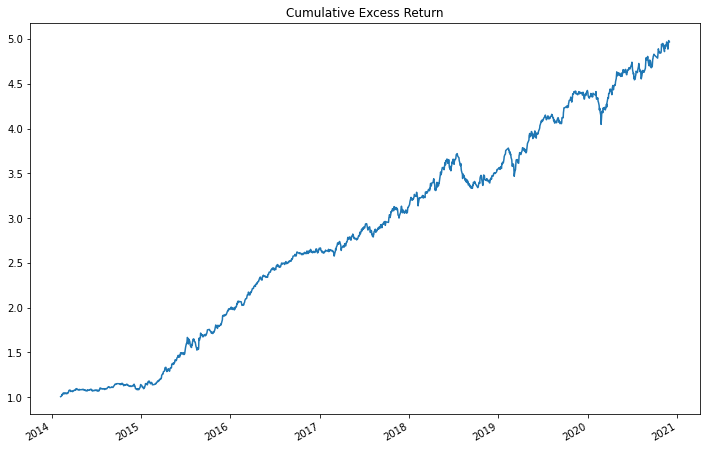

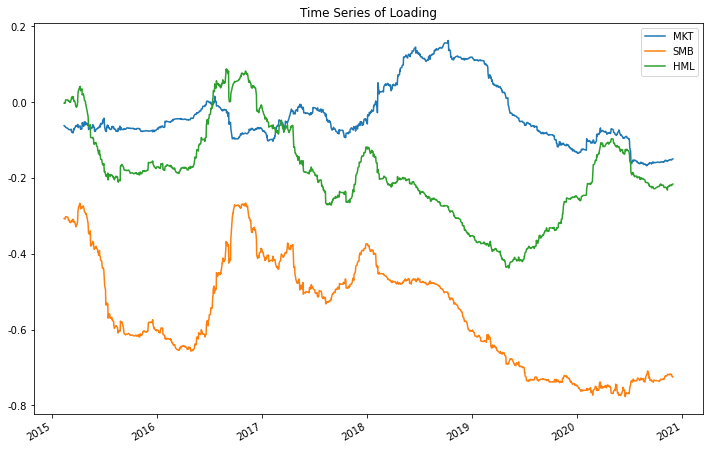

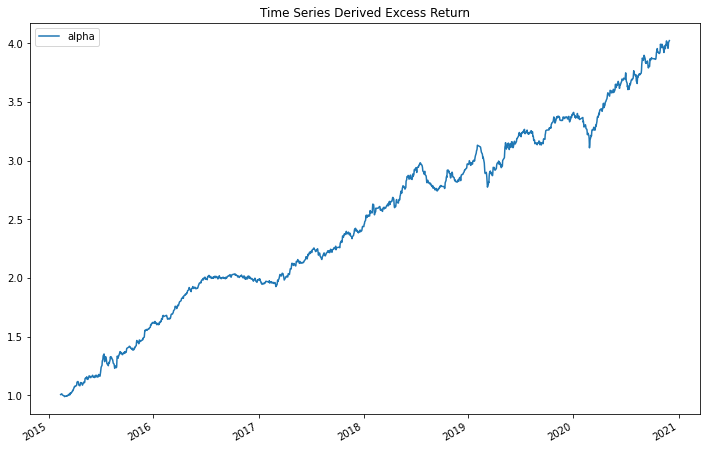

In [151]:
factor = pd.read_csv(os.path.join(DATA_ROOT, 'data/payoffs/anomaly/ROE.csv'), index_col=0, parse_dates=True)['ROE_0011']

analyse_factor_on_model(factor, 'FF3', 'simplified', START_DATE, END_DATE)

All Time Correlation


,MKT
ROE_0011,-0.23446


Time Series of Correlation


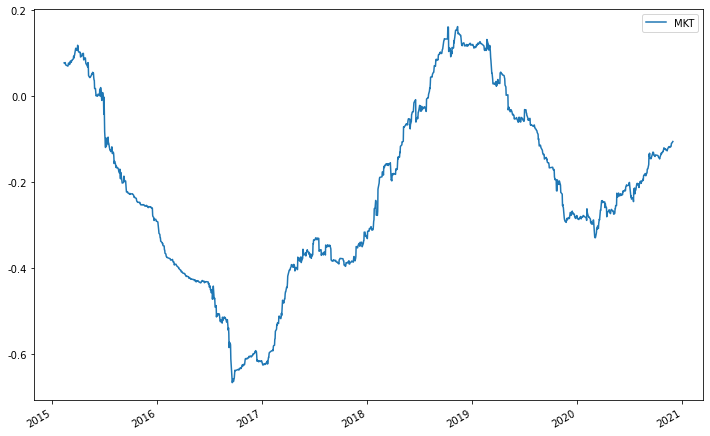

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ROE_0011   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     96.62
Date:                Tue, 05 Jan 2021   Prob (F-statistic):           3.34e-22
Time:                        17:25:55   Log-Likelihood:                 5342.3
No. Observations:                1663   AIC:                        -1.068e+04
Df Residuals:                    1661   BIC:                        -1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.616      0.009       0.000       0.001
MKT           -0.1599      0.016     -9.830      0.000      -0.192      -0.128
==============================================================================
Omnibus:                      348.884   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3384.080
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                       9.850   Cond. No.                         68.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

alpha p.a.: 0.13316425443434582


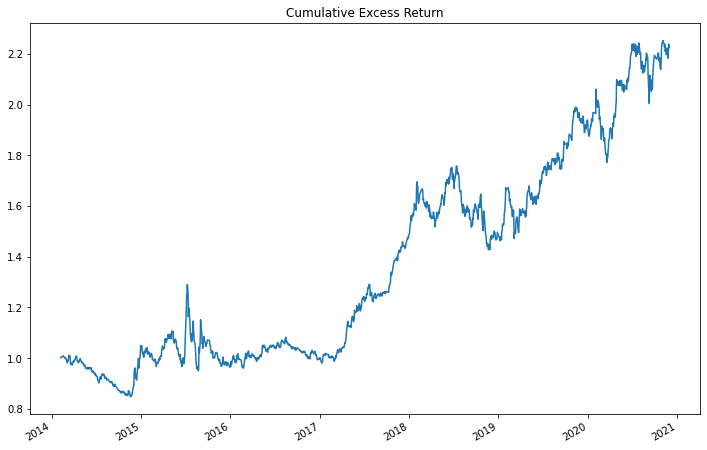

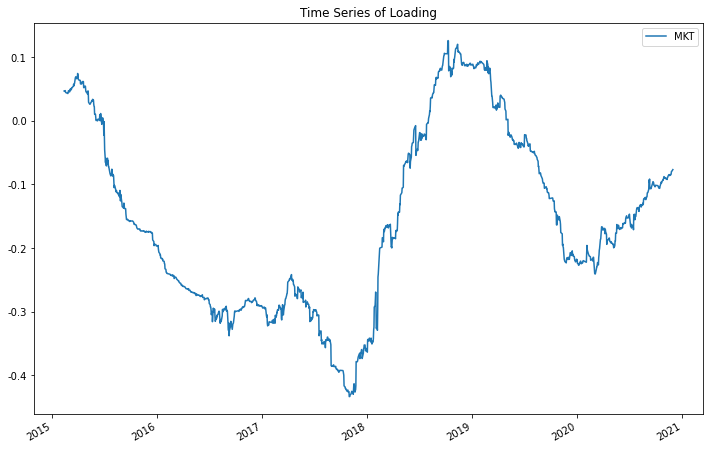

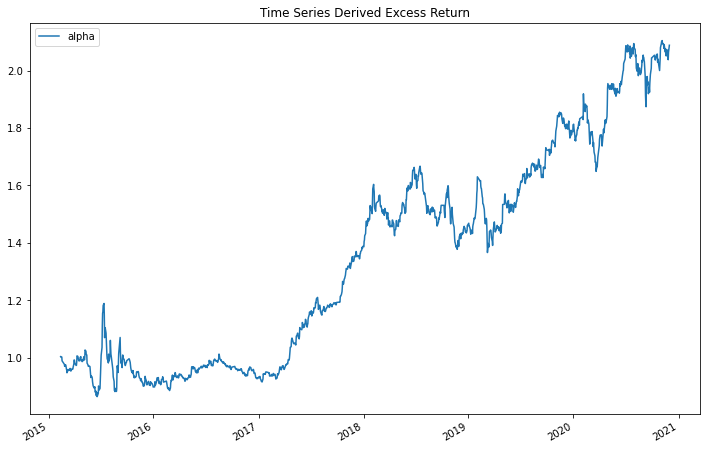

In [153]:
factor = pd.read_csv(os.path.join(DATA_ROOT, 'data/payoffs/anomaly/ROE.csv'), index_col=0, parse_dates=True)['ROE_0011']

analyse_factor_on_model(factor, 'CAPM', 'simplified', START_DATE, END_DATE)